In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn_evaluation.plot import grid_search

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity

import statsmodels.api as sm  # For fitting statistical models
import statsmodels.formula.api as smf  # For fitting statistical models using formulas


In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Crimes_2022.csv')

In [121]:
df = pd.read_csv('https://data.cityofchicago.org/api/views/9hwr-2zxp/rows.csv?accessType=DOWNLOAD')

In [122]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12592454,JF113025,01/14/2022 03:55:00 PM,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,16.0,68,26,1170805.0,1860170.0,2022,09/14/2023 03:41:59 PM,41.771782,-87.649437,"(41.771782439, -87.649436929)"
1,12785595,JF346553,08/05/2022 09:00:00 PM,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,5.0,69,17,1185135.0,1857211.0,2022,09/14/2023 03:41:59 PM,41.763338,-87.597001,"(41.763337967, -87.597001131)"
2,12808281,JF373517,08/14/2022 02:00:00 PM,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,39.0,11,17,1138383.0,1937953.0,2022,09/14/2023 03:41:59 PM,41.985875,-87.766404,"(41.985875279, -87.766403857)"
3,12888104,JF469015,11/10/2022 03:47:00 AM,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,17.0,68,15,1169903.0,1856822.0,2022,09/14/2023 03:41:59 PM,41.762615,-87.652840,"(41.76261474, -87.652840463)"
4,13209277,JG422539,08/15/2022 09:00:00 AM,0000X W JACKSON BLVD,0810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,4.0,32,06,NaN,NaN,2022,09/14/2023 03:43:09 PM,NaN,NaN,NaN


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239602 entries, 0 to 239601
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    239602 non-null  int64  
 1   Case Number           239602 non-null  object 
 2   Date                  239602 non-null  object 
 3   Block                 239602 non-null  object 
 4   IUCR                  239602 non-null  object 
 5   Primary Type          239602 non-null  object 
 6   Description           239602 non-null  object 
 7   Location Description  238633 non-null  object 
 8   Arrest                239602 non-null  bool   
 9   Domestic              239602 non-null  bool   
 10  Beat                  239602 non-null  int64  
 11  District              239602 non-null  int64  
 12  Ward                  239592 non-null  float64
 13  Community Area        239602 non-null  int64  
 14  FBI Code              239602 non-null  object 
 15  

In [124]:
df.shape

(239602, 22)

## Data Cleaning:

In [126]:
df = df.drop(columns=['ID','Case Number','Year','Location','Block','Primary Type', 'Updated On'])
df['Domestic'] =  df['Domestic'].astype(int) # Converting out of Boolean
df['Arrest'] = df['Arrest'].astype(int)

In [127]:
df = df.drop(columns=['X Coordinate', 'Y Coordinate'])

In [128]:
df['IUCR'] = df['IUCR'].str.extract(r'(\d+)', expand=False).astype(int)

In [129]:
df['FBI Code'] = df['FBI Code'].str.extract(r'(\d+)', expand=False).astype(int)

In [130]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')

In [131]:
# df['Updated On'] = pd.to_datetime(df['Updated On'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')

In [132]:
df = df.dropna()
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234233 entries, 0 to 239601
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  234233 non-null  datetime64[ns]
 1   IUCR                  234233 non-null  int64         
 2   Description           234233 non-null  object        
 3   Location Description  234233 non-null  object        
 4   Arrest                234233 non-null  int64         
 5   Domestic              234233 non-null  int64         
 6   Beat                  234233 non-null  int64         
 7   District              234233 non-null  int64         
 8   Ward                  234233 non-null  float64       
 9   Community Area        234233 non-null  int64         
 10  FBI Code              234233 non-null  int64         
 11  Updated On            234233 non-null  datetime64[ns]
 12  Latitude              234233 non-null  float64       
 13  Long

In [117]:
districts_to_keep = [1, 13, 12, 11, 2, 9, 16, 14]


In [118]:
filtered_df = df[df['District'].isin(districts_to_keep)].drop_duplicates()

In [14]:
filtered_df.shape

(78084, 14)

In [15]:
num_true_arrests = df['Arrest'].sum()
print(f"Number of True Arrests: {num_true_arrests}")
total_cases = len(df)
print(f"Total Number of Crime Cases: {total_cases}")
print(f"Percentage of True Arrests: {num_true_arrests/total_cases*100}%") # The data is imbalanced

Number of True Arrests: 27246
Total Number of Crime Cases: 234233
Percentage of True Arrests: 11.632007445577694%


In [ ]:
# cos_sim_df = pd.DataFrame(cos_sim, index=df['Description'], columns=df['Description'])

# # Plot the heatmap
# plt.figure(figsize=(12, 12), dpi=300)
# sns.heatmap(cos_sim_df, cmap='coolwarm', annot=True, fmt='.2g', annot_kws={"size": 5}, xticklabels=True, yticklabels=True)
# plt.title("Cosine Similarity Heatmap")
# plt.savefig('StringSimilarityHeatmap.jpg', format='jpeg', dpi=300, bbox_inches='tight')
# plt.show()

In [69]:
cat_cols = list(df.select_dtypes(include='object').columns)

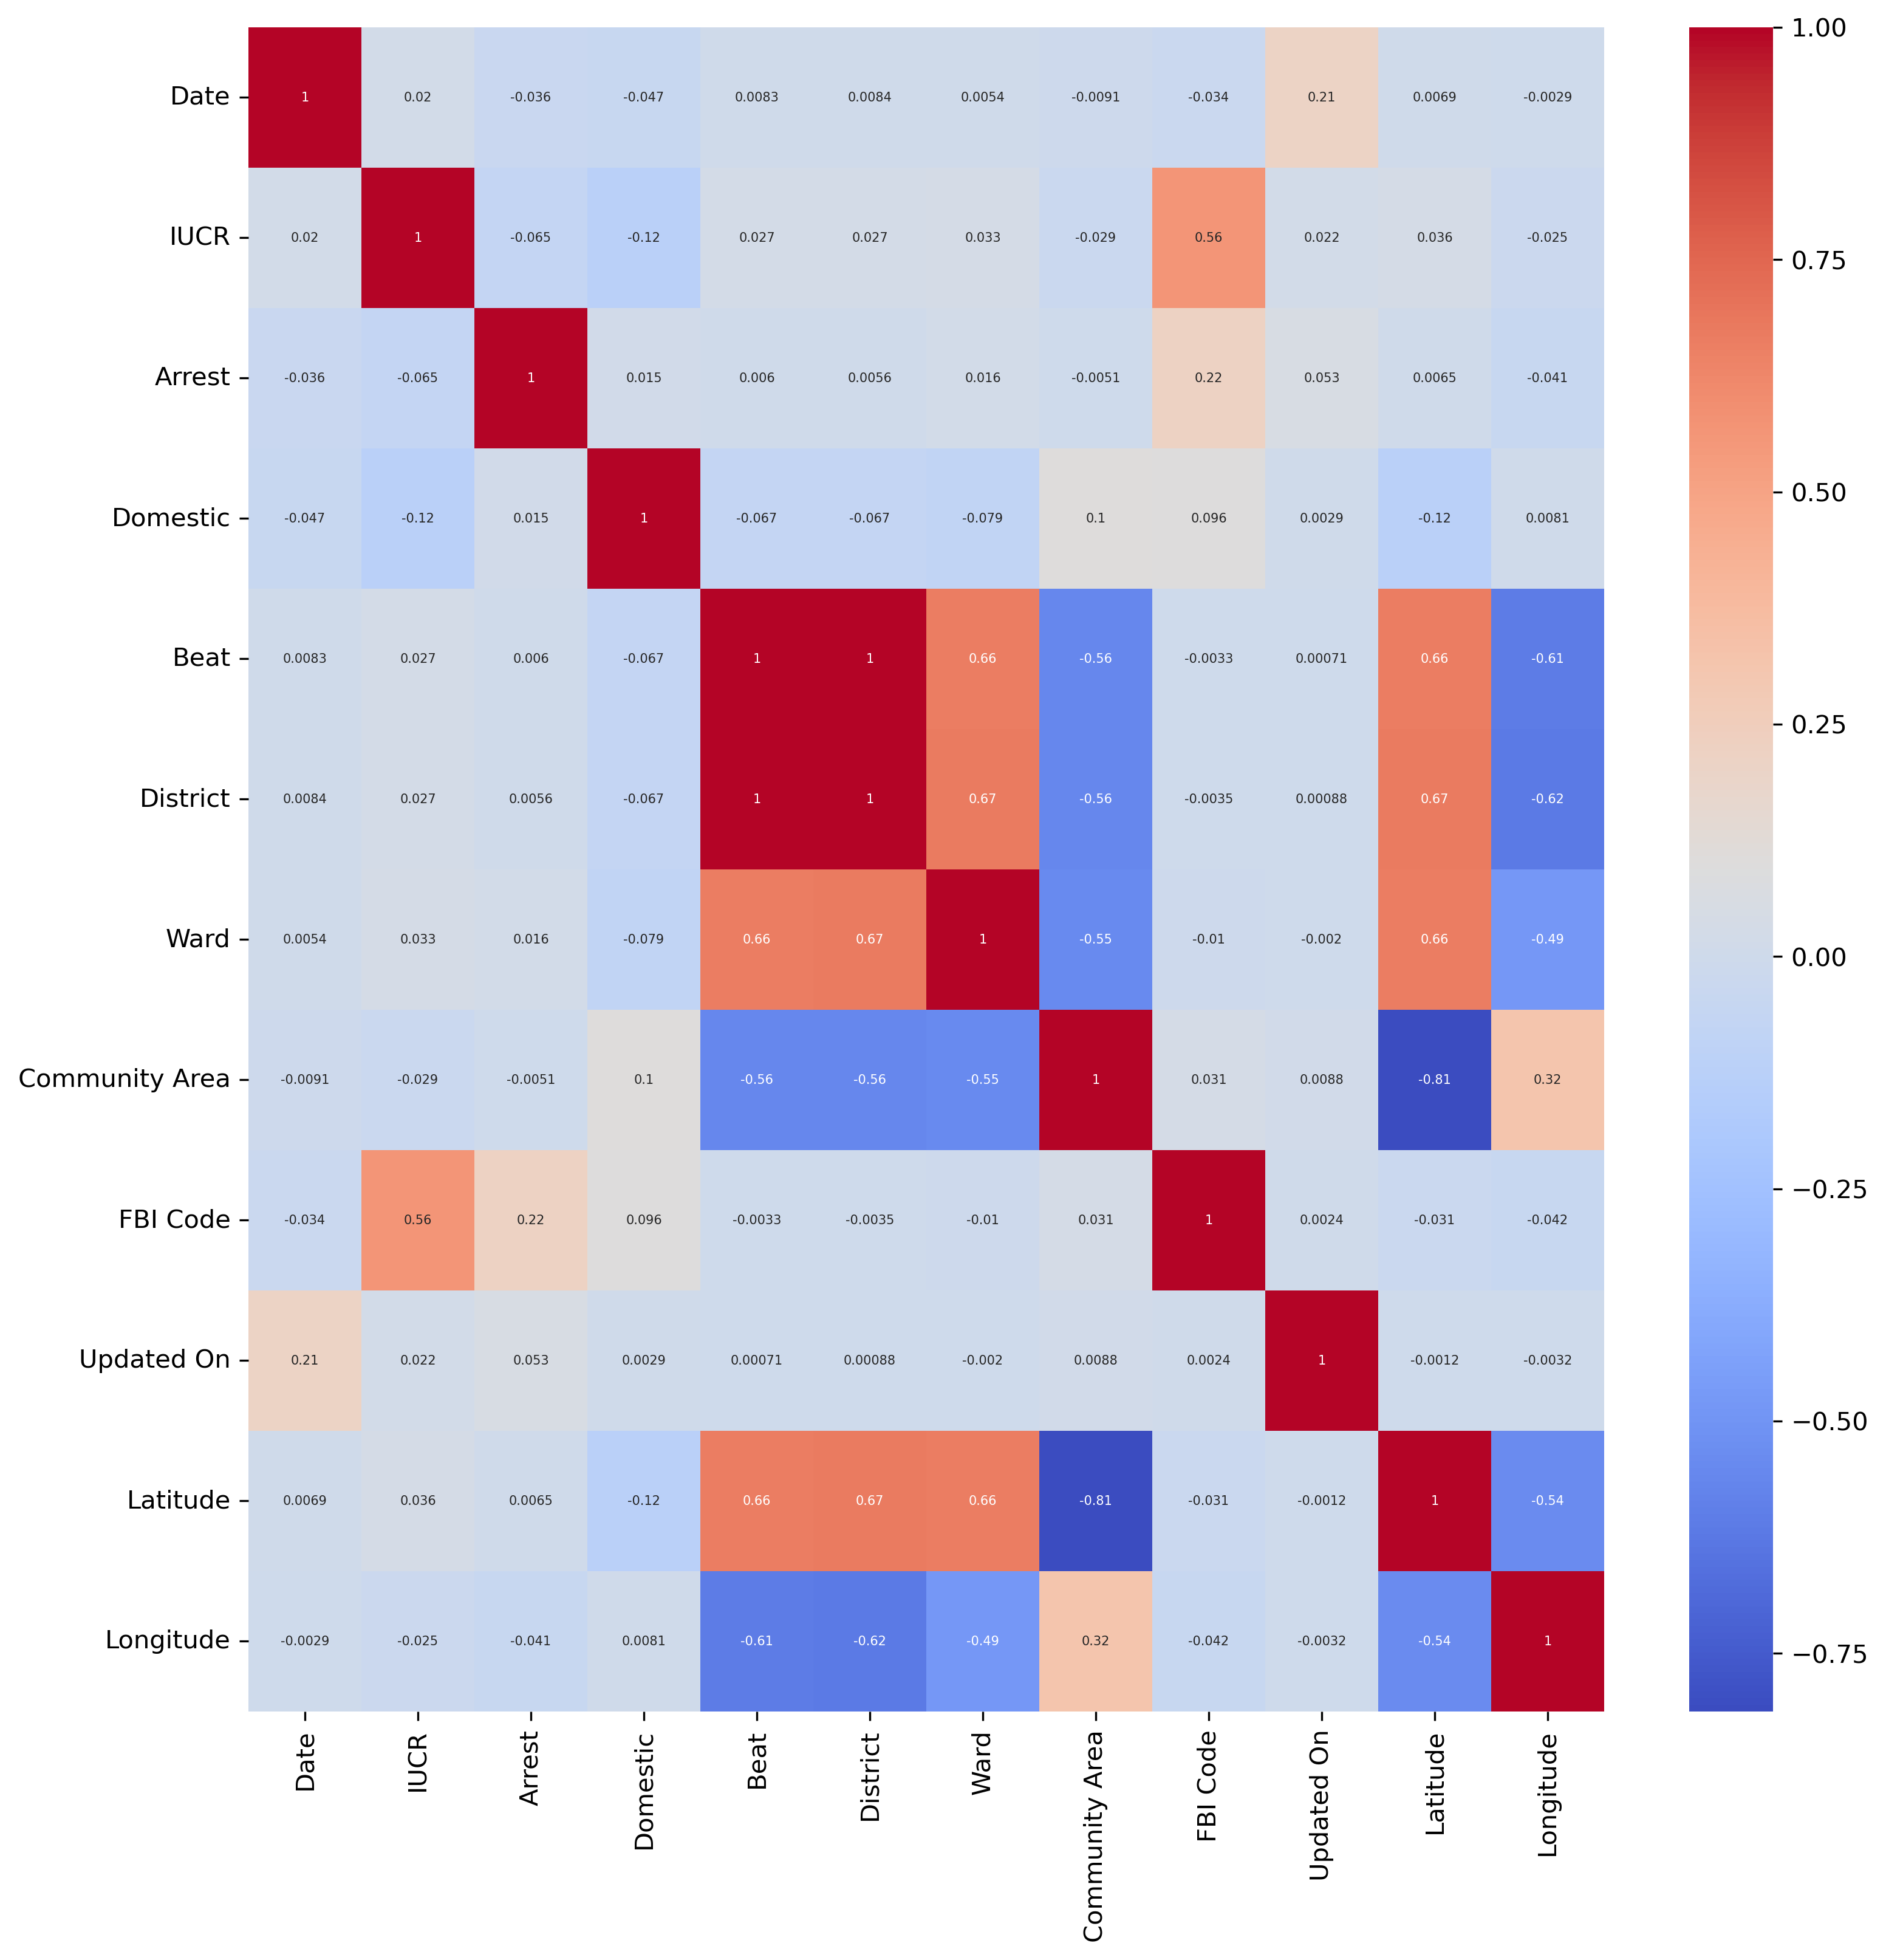

In [101]:
plt.figure(figsize=(12,12),dpi=300)
corr = df.drop(columns=cat_cols).corr(method = 'spearman')
sns.heatmap(corr, cmap ='coolwarm',fmt='.2g',annot=True, annot_kws={"size":5}, xticklabels=1, yticklabels=1)
plt.savefig('SpearmanCorrHeat.jpg', format='jpeg', dpi=300, bbox_inches ='tight')

# Data Split & Preprocessing

In [102]:
X = df.drop(columns=['Arrest'])
y = df['Arrest']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [67]:
num_cols = list(X_train.select_dtypes(include=np.number).columns)
cat_cols = list(X_train.select_dtypes(include='object').columns)

In [92]:
print(num_cols)
print(cat_cols)

['IUCR', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Latitude', 'Longitude']
['Description', 'Location Description']


In [104]:
rf = RandomForestClassifier()
ct = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('desc', TargetEncoder(), ['Description']),
    ('loc_desc',OneHotEncoder(handle_unknown='ignore'), ['Location Description'])
])

pipe_rf = Pipeline([
    ('ct', ct),
    ('clf', rf)

])
param_grid_rf = [{'clf':[rf], 'clf__max_depth': [2,4,6], 'clf__n_estimators': [200,500,1000]}]

np.random.seed(7)
gridSearch_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, scoring='r2', n_jobs=-1, cv=5)
gridSearch_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['IUCR',
                                                                          'Domestic',
                                                                          'Beat',
                                                                          'District',
                                                                          'Ward',
                                                                          'Community '
                                                                          'Area',
                                                                          'FBI '
                                                                          'Code',
                                                                          'Latitude',
                                                                          'Longitude']),
                                                                        ('desc',
                                                                         TargetEncoder(),
                                                                         ['Description']),
                                                                        ('loc_desc',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Location '
                                                                          'Description'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'clf': [RandomForestClassifier()],
                          'clf__max_depth': [2, 4, 6],
                          'clf__n_estimators': [200, 500, 1000]}],
             scoring='r2')

In [4]:
fig = plt.figure
grid_search(gridSearch_rf.cv_results_, change='clf__n_estimators')

NameError: name 'gridSearch_rf' is not defined